In [9]:
#import packages
import numpy as np
import copy
import pandas
import os
import imp
import pickle
from scipy.interpolate import interp1d
import warnings
import time
import matplotlib.pyplot as plt
import inspect
import types
import math as mat
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import datetime
from matplotlib import animation
from IPython.display import HTML
from tempfile import NamedTemporaryFile
import matplotlib.backends.backend_pdf
from scipy import interpolate
from itertools import groupby
import re
import csv
import copy
from fnmatch import fnmatch
import json
import h5py 
import copy
import math
pi = math.pi

sns.set()
sns.set_style()
%matplotlib inline

In [10]:
#ledpanels

def get_idx_panels_commands(ledpanels_command):
#gets the indeces of the set pattern id command and
# the gain command
    idx_pat_command = [i for i, x in enumerate(all_ledpanels_command[i])
               if x == b'set_pattern_id']
    idx_gain_command = [i for i, x in enumerate(all_ledpanels_command[i])
               if x == b'send_gain_bias']
    return idx_pat_command, idx_gain_command

#alicat, wind flow

def read_in_wind_flow_parameters(alicat_devices_topic):
#read in and strip the alicat message
#returns the 
    allmsg = str(alicat_devices_topic)
    allmsg_line = allmsg.split('\\n')
    
    allmsg_split = []
    for i in allmsg_line:
        msg_split = str(i).split(':')
        allmsg_split.append(msg_split)
    
    allmsg_stripped = []
    for i in allmsg_split:
        allmsg_pairs = []
        for j in i:
            msg_stripped = str(j).strip('    ')
            allmsg_pairs.append(msg_stripped)    
        allmsg_stripped.append(allmsg_pairs)
    
    return allmsg_stripped

def get_alicat_parameters(allmsg_stripped):
    
    n = 6 #number of addresses (or devices)
    
    #getting addresses
    adresses_file = []
    alicat_seq_file = []
    rate_set_point_file = []
    rate_actual_file = []
    success_file = []
    for i in range(len(allmsg_stripped)):
        for j in range(len(allmsg_stripped[i])):
            if allmsg_stripped[i][j] == 'address':
                adresses_file.append(allmsg_stripped[i][1][1])
            elif allmsg_stripped[i][j] == 'seq':
                alicat_seq_file.append(int(allmsg_stripped[i][1]))
            elif allmsg_stripped[i][j] == 'rate_set_point':
                rate_set_point_file.append(float(allmsg_stripped[i][1]))  
            elif allmsg_stripped[i][j] == 'rate_actual':
                rate_actual_file.append(float(allmsg_stripped[i][1]))   
            elif allmsg_stripped[i][j] == 'success':
                success_file.append((allmsg_stripped[i][1])) 
           
    adresses_file_dev = [adresses_file[x:x+n] for x in range(0, len(adresses_file),n)]
    rate_set_point_file_dev = [rate_set_point_file[x:x+n] for x in range(0, len(rate_set_point_file),n)]
    rate_actual_file_dev = [rate_actual_file[x:x+n] for x in range(0, len(rate_actual_file),n)]
    success_file_dev = [success_file[x:x+n] for x in range(0, len(success_file),n)]
    
    lists_to_check = [adresses_file_dev, rate_set_point_file_dev, rate_actual_file_dev, success_file_dev]
    
    for i in lists_to_check:
        for j in i:
            if len(j) != n:
                raise Exception('something is wrong with msg')
            
    for i in lists_to_check:
        if len(i) != len(alicat_seq_file):
            raise Exception('something is wrong with msg')  
            
    return alicat_seq_file, adresses_file_dev, rate_set_point_file_dev, rate_actual_file_dev, success_file_dev

def get_changes_set_point(rate_set_point_file):
    idx_changes_set_point_l = []
    for i in range(len(rate_set_point_file)-1):
        if i == 0 :
            idx = i
        elif rate_set_point_file[i] != rate_set_point_file[i+1]:
            idx = i+1
        elif i == len(rate_set_point_file)-2:
            idx = i+1 
        idx_changes_set_point_l.append(idx)
        
    idx_changes_set_point = np.unique(np.asarray(idx_changes_set_point_l))
    
    return idx_changes_set_point

def get_consecutive_pairs(myarray):
    start_frames = []
    end_frames = []
    for i in range(len(myarray)-1):
        s = myarray[i]
        e = myarray[i + 1]  
        start_frames.append(s)
        end_frames.append(e)
    return start_frames, end_frames

In [11]:
#functions
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_elapsed_time(my_list):
#for list of lists
    all_t_ellapsed = []
    for i in range(len(my_list)):
        t_ellapsed = my_list[i] - my_list[i][0]
        all_t_ellapsed.append(t_ellapsed)
    return all_t_ellapsed

def smallestSignedAngleBetween(x, y):
    a = math.atan2(math.sin(y-x), math.cos(y-x))
    return a

def get_smallestSignedAngleBetween(ax, y):
    yy=np.deg2rad(np.ones(len(ax))*y)
    axx = np.deg2rad(ax)
    
    array_smallestsignedangle = []
    for k in range(len(ax)):
        kk = smallestSignedAngleBetween(axx[k], yy[k])*-1
        kk = (np.rad2deg(kk))
        array_smallestsignedangle.append(kk)
    
    return array_smallestsignedangle

def circmean(alpha,axis=None):
    mean_angle = np.arctan2(np.mean(np.sin(alpha),axis),np.mean(np.cos(alpha),axis))
    return mean_angle

def circvar(alpha,axis=None):
#### vector strength = 1 - circvar
#     if np.ma.isMaskedArray(alpha) and alpha.mask.shape!=():
#         N = np.sum(~alpha.mask,axis)
#     else:
#         if axis is None:
#             N = alpha.size
#         else:
#             N = alpha.shape[axis]
    R = np.sqrt(np.sum(np.sin(alpha),axis)**2 + np.sum(np.cos(alpha),axis)**2)/len(alpha)
    V = 1-R
    return R

In [12]:
dataDir = '/Users/fponce/Documents/vdesert/VD_101619/data'

pattern_vdesert_data = "*.hdf5"
exp = 'VD_101619'

#ledpanels info about patterns used:
#pattern table used from vdesert params
#pattern_angles should correspond to pattern_ids 1 to 1

pattern_ids = [1,2,3,4,5,6,7,8,\
               9,10,11,12,13,14,15,16,\
               17,18,19,20,21,22,23,24]

pattern_angles = [45, 135, 90, 180, -45, 0, -90, -135,\
                  45, 135, 90, 180, -45, 0, -90, -135,\
                  -135, 45, 135, -45, 90, 180, -90, 0]

pattern_type = [0,1,2]

# type1 - 0-8 big blobs - camo 
# type2 - 9-16 small blobs - starfield
# type3 - 17-24 stripes


#sunleds

led_ids = [0, 1, 18, 36, 54, 72, 90, 108, 126]

led_ids_angles = ['NaN', 180, 135, 90, 45, 0, -45, -90, -135]


#vector indicating the idx of trials that need to be analyzed
all_trials_ids = range(13)

#for magnotether angle interpolation
number_trials = 13
time_each_trial = [60,60,60,60,180,10,180,180,180,180,180,180,180]
experiment_time = np.sum(np.asarray(time_each_trial))
number_frames_per_sec = 30

print(experiment_time)
print(experiment_time*30)

1690
50700


In [13]:
#import data
datapaths = []
for path, subdirs, files in os.walk(dataDir):
    for name in files:
        if fnmatch(name, pattern_vdesert_data):
            datapaths.append(os.path.join(path, name))
            
print(datapaths[-1])
print(len(datapaths))

#check for keys
for i in range(len(datapaths)):
    f = h5py.File(datapaths[i], "r")
    datasetNames = [n for n in f.keys()]
print(datasetNames)

/Users/fponce/Documents/vdesert/VD_101619/data/data_2019-10-22-13-35-10.hdf5
16
['alicat_devices', 'alicat_ros_tstamps', 'alicat_tsstamp', 'angle', 'autostep_action_running', 'autostep_action_started', 'autostep_action_stopped', 'current_trial_index', 'elapsed_time', 'flow_action_running', 'flow_action_started', 'flow_action_stopped', 'init_angle', 'ledpanels_panels_arg1', 'ledpanels_panels_arg2', 'ledpanels_panels_arg3', 'ledpanels_panels_arg4', 'ledpanels_panels_arg5', 'ledpanels_panels_arg6', 'ledpanels_panels_command', 'ledpanels_ros_tstamps', 'magnotether_angle', 'magnotether_frame', 'magnotether_ros_tstamps', 'magnotether_tstamps', 'motion_data_position', 'motion_data_ros_tstamps', 'motion_data_seq', 'motion_data_setpoint', 'motion_data_time', 'motion_data_tstamps', 'name', 'panels_action_running', 'panels_action_started', 'panels_action_stopped', 'ros_tstamps', 'seq', 'sun_blue', 'sun_green', 'sun_led_number', 'sun_message', 'sun_red', 'sun_ros_tstamps', 'sun_success', 'sun_tsst

In [14]:
#hdf5 -> np.arrays
all_params_ts = []
all_data_params = []

all_ros_ts = []
all_ts = []
all_elapsed_time = []
all_trial_index = []
all_trial_elapsed_time = []
all_angle_for_autostep = []
all_init_angle = []
all_autostep_running = []
all_autostep_started = []
all_autostep_stopped = []
all_flow_running = []
all_flow_started = []
all_flow_stopped = []
all_panels_running = []
all_panels_started = []
all_panels_stopped = []

all_magnotether_angle = []
all_magnotether_ros_tstamps = []
all_magnotether_tstamps = []

all_motion_ros_tstamps = []
all_motion_tstamps = []
all_motion_setpoint = []
all_motion_position = []

all_ledpanels_ros_tstamps = []
all_ledpanels_command = []
all_ledpanels_1 = []
all_ledpanels_2 = []
all_ledpanels_3 = []
all_ledpanels_4 = []
all_ledpanels_5 = []
all_ledpanels_6 = []

all_alicat_ros_tstamps = []
all_alicat_devices = []

all_sun_ros_tstamps = []
all_sun_red = []
all_sun_green = []
all_sun_blue = []
all_sun_message = []
all_sun_led_number = []

for i in range(len(datapaths)):
    f = h5py.File(datapaths[i], "r")
    
    #parameters topic
#     params_ts = np.asarray(f['data_params_ros_tstamps'])
#     data_params = np.asarray(f['data_params'])
    
    #virtual_desert topic
    ros_ts = np.asarray(f['ros_tstamps'])
    ts = np.asarray(f['tstamps'])
    elapsed_time = np.asarray(f['elapsed_time'])
    trial_index = np.asarray(f['current_trial_index'])
    trial_elapsed_time = np.asarray(f['trial_e_time'])
    angle_for_autostep = np.asarray(f['angle'])
    init_angle = np.asarray(f['init_angle'])
    
    #actions
    autostep_running = np.asarray(f['autostep_action_running'])
    autostep_started = np.asarray(f['autostep_action_started'])
    autostep_stopped = np.asarray(f['autostep_action_stopped'])
    
    flow_running = np.asarray(f['flow_action_running'])
    flow_started = np.asarray(f['flow_action_started'])
    flow_stopped = np.asarray(f['flow_action_stopped'])  
    
    panels_running = np.asarray(f['panels_action_running'])
    panels_started = np.asarray(f['panels_action_started'])
    panels_stopped = np.asarray(f['panels_action_stopped'])      
    
    #magnotether_angle topic
    magnotether_angle = np.asarray(f['magnotether_angle'])
    magnotether_ros_tstamps = np.asarray(f['magnotether_ros_tstamps'])
    magnotether_tstamps = np.asarray(f['magnotether_tstamps'])
    
    #motion_data topic
    motion_ros_tstamps = np.asarray(f['motion_data_ros_tstamps'])
    motion_tstamps = np.asarray(f['motion_data_tstamps'])
    motion_setpoint = np.asarray(f['motion_data_setpoint'])
    motion_position = np.asarray(f['motion_data_position'])
    
    #ledpanels topic
    ledpanels_ros_tstamps = np.asarray(f['ledpanels_ros_tstamps'])
    ledpanels_command = np.asarray(f['ledpanels_panels_command'])
    ledpanels_1 = np.asarray(f['ledpanels_panels_arg1'])
    ledpanels_2 = np.asarray(f['ledpanels_panels_arg2'])
    ledpanels_3 = np.asarray(f['ledpanels_panels_arg3'])
    ledpanels_4 = np.asarray(f['ledpanels_panels_arg4']) 
    ledpanels_5 = np.asarray(f['ledpanels_panels_arg5']) 
    ledpanels_6 = np.asarray(f['ledpanels_panels_arg6']) 
    
    #alicat topic
    alicat_ros_tstamps = np.asarray(f['alicat_ros_tstamps'])
    alicat_devices = np.asarray(f['alicat_devices'])
    
    #sun topic
    sun_ros_tstamps = np.asarray(f['sun_ros_tstamps'])
    sun_red = np.asarray(f['sun_red'])
    sun_green = np.asarray(f['sun_green'])
    sun_blue = np.asarray(f['sun_blue'])
    sun_message = np.asarray(f['sun_message'])
    sun_led_number = np.asarray(f['sun_led_number'])
    
#     all_params_ts.append(params_ts)
#     all_data_params.append(data_params)

    all_ros_ts.append(ros_ts)
    all_ts.append(ts)
    all_elapsed_time.append(elapsed_time)
    all_trial_index.append(trial_index)
    all_trial_elapsed_time.append(trial_elapsed_time)
    all_angle_for_autostep.append(angle_for_autostep)
    all_init_angle.append(init_angle)
    all_autostep_running.append(autostep_running)
    all_autostep_started.append(autostep_started)
    all_autostep_stopped.append(autostep_stopped)
    all_flow_running.append(flow_running)
    all_flow_started.append(flow_started)
    all_flow_stopped.append(flow_stopped)
    all_panels_running.append(panels_running)
    all_panels_started.append(panels_started)
    all_panels_stopped.append(panels_stopped)
    all_magnotether_angle.append(magnotether_angle)
    all_magnotether_ros_tstamps.append(magnotether_ros_tstamps)
    all_magnotether_tstamps.append(magnotether_tstamps)
    all_motion_ros_tstamps.append(motion_ros_tstamps)
    all_motion_tstamps.append(motion_tstamps)
    all_motion_setpoint.append(motion_setpoint)
    all_motion_position.append(motion_position)
    all_ledpanels_1.append(ledpanels_1)
    all_ledpanels_2.append(ledpanels_2)
    all_ledpanels_3.append(ledpanels_3)
    all_ledpanels_4.append(ledpanels_4)
    all_ledpanels_5.append(ledpanels_5)
    all_ledpanels_6.append(ledpanels_6)
    all_ledpanels_command.append(ledpanels_command)
    all_ledpanels_ros_tstamps.append(ledpanels_ros_tstamps)
    all_alicat_ros_tstamps.append(alicat_ros_tstamps)
    all_alicat_devices.append(alicat_devices)   
    all_sun_ros_tstamps.append(sun_ros_tstamps)
    all_sun_red.append(sun_red)
    all_sun_green.append(sun_green)
    all_sun_blue.append(sun_blue)
    all_sun_led_number.append(sun_led_number)

In [15]:
# #quick check for flies that completed all the trials

# for i in range(len(datapaths)):
#     print(np.unique(all_trial_index[i]))
    
# #quick look at  magnotether data
# for i in range(len(all_magnotether_angle)):
#     plt.figure(figsize = (25,5))
#     plt.plot(all_magnotether_angle[i])
#     plt.title(datapaths[i])

In [16]:
#this gets the start and end times(all_elapsed_time) when the trial changes in the virtual desert node

all_start_times = []
all_end_times = []
for i in range(len(datapaths)):
    start_times_trials = []
    end_times_trials = []
    for j in range(number_trials):
        start_time = all_elapsed_time[i][np.where(all_trial_index[i]==j)][0]
        end_time = all_elapsed_time[i][np.where(all_trial_index[i]==j)][-1]
        start_times_trials.append(start_time)
        end_times_trials.append(end_time)
    all_start_times.append(start_times_trials)
    all_end_times.append(end_times_trials)
    
#print(len(all_start_times[0]))
# print(all_end_times[0])

all_start_frames = []
all_end_frames = []
for i in range(len(datapaths)):
    start_frames_trials = []
    end_frames_trials = []
    for j in range((number_trials)):
        start_frame = [np.where(all_trial_index[i]==j)][0][0][0]
        end_frame = [np.where(all_trial_index[i]==j)][0][0][-1]
        start_frames_trials.append(start_frame)
        end_frames_trials.append(end_frame)
    all_start_frames.append(start_frames_trials)
    all_end_frames.append(end_frames_trials)
print(len(all_start_frames[0]))
# print(all_end_frames[0])

13


In [17]:
#interpolation of magnotether angles

t = [0, experiment_time]
reg_t = np.linspace(t[0], t[-1],(experiment_time*number_frames_per_sec)+1)

#getting elapsed time of time stamps to use
all_ts = get_elapsed_time(all_magnotether_ros_tstamps)

#making the interpolation
all_magnotether_interp_angles = []
for i in range(len(datapaths)):       
    mysecs_np = all_ts[i]
    myangles_np = all_magnotether_angle[i]    
    f_a = interp1d(mysecs_np, myangles_np, bounds_error=False)
    reg_a = f_a(reg_t)
    all_magnotether_interp_angles.append(reg_a)

In [18]:
#get the closest times that correspond to start and end times in the reg_t
all_magnotether_elapsed = reg_t

all_start_times_m = []    
all_end_times_m = []   
for i in range(len(all_start_times)): 
    start_times_trials_m = []
    end_times_trials_m = []    
    for j in range((number_trials)):
        start_times_m = find_nearest(all_magnotether_elapsed, all_start_times[i][j])
        end_times_m = find_nearest(all_magnotether_elapsed, all_end_times[i][j])
        start_times_trials_m.append(start_times_m)
        end_times_trials_m.append(end_times_m)
    all_start_times_m.append(start_times_trials_m)    
    all_end_times_m.append(end_times_trials_m)     
    
# print(all_end_times_m[0])   

all_start_frames_m = []    
all_end_frames_m = []   
for i in range(len(all_start_times)): 
    start_frames_trials_m = []
    end_frames_trials_m = []    
    for j in range((number_trials)):
        start_frames_m = find_nearest_idx(all_magnotether_elapsed, all_start_times[i][j])
        end_frames_m = find_nearest_idx(all_magnotether_elapsed, all_end_times[i][j])
        start_frames_trials_m.append(start_frames_m)
        end_frames_trials_m.append(end_frames_m)
    all_start_frames_m.append(start_frames_trials_m)    
    all_end_frames_m.append(end_frames_trials_m)     
    
print(len(all_start_frames_m[0]))
# print(all_end_frames_m[0]) 
# print(all_start_times_m[0])   
# print(all_end_times_m[0])

13


In [19]:
#get ledpanels info

#gets the indeces of the set pattern id command
all_idx_pat_command = []
all_idx_gain_command = []
for i in range(len(datapaths)):
    idx_pat_command, idx_gain_command = get_idx_panels_commands(ledpanels_command)
    all_idx_pat_command.append(idx_pat_command)
    all_idx_gain_command.append(idx_gain_command)
    
#get elapsed time of panels
all_ledpanels_elapsed_t = get_elapsed_time(all_ledpanels_ros_tstamps)

#get the timestamp and elapsed time of the set pattern id command
all_ros_tstamps_pat_id = []
all_ledpanels_elapsed_t_pat_id  = []
for i in range(len(all_idx_pat_command)):
    ros_tstamps_pat_id_file = []
    ledpanels_elapsed_t_pat_id_file = []
    for j in (all_idx_pat_command[i]):
        ros_tstamps_pat_id = all_ledpanels_ros_tstamps[i][j]
        ledpanels_elapsed_t_pat_id = all_ledpanels_elapsed_t[i][j]
        
        ros_tstamps_pat_id_file.append(ros_tstamps_pat_id)
        ledpanels_elapsed_t_pat_id_file.append(ledpanels_elapsed_t_pat_id)
        
    all_ros_tstamps_pat_id.append(ros_tstamps_pat_id_file)
    all_ledpanels_elapsed_t_pat_id.append(ledpanels_elapsed_t_pat_id_file) 
    
#get arg1 for pannel_id command and gains
#get the arg1 for the rows of pattern_id command
all_pattern_id = []
for i in range(len(all_idx_pat_command)):
    pattern_id_file = []
    for j in (all_idx_pat_command[i]):
        arg1 = all_ledpanels_1[i][j]
        pattern_id_file.append(arg1)
    all_pattern_id.append(pattern_id_file)
    
#get the arg1 for the rows of gain command
all_gains = []
for i in range(len(all_idx_gain_command)):
    gains_file = []
    for j in (all_idx_gain_command[i]):
        arg1 = all_ledpanels_1[i][j]
        gains_file.append(arg1)
    all_gains.append(gains_file)
    
# print(all_ledpanels_elapsed_t_pat_id[0])
#print(all_pattern_id[0])
# print((all_gains))

In [20]:
# experiment dependant
# map pattern_ids with angles in lab corrdinates

all_pat_angles = []
for i in range(len(all_pattern_id)):
    pat_angles_file = []
    for j in range(len(all_pattern_id[i])):
        p = pattern_angles[all_pattern_id[i][j]-1]# -1 bc pattern id start at 1
        pat_angles_file.append(p)
    all_pat_angles.append(pat_angles_file)
#print(all_pat_angles)

lp_to_lpvdesert = [0,1,2,3,4,'NaN','NaN','NaN',5,5,6,6,7]

all_pat_angles_vd = []
for i in range(len(all_pat_angles)):
    lp_vd = []
    for j in range(len(lp_to_lpvdesert)):
        try:
            lp = all_pat_angles[i][lp_to_lpvdesert[j]]
        except:
            lp = 'NaN'
        lp_vd.append(lp)
    all_pat_angles_vd.append(lp_vd)


all_gains_vd = []
for i in range(len(all_gains)):
    lp_vd = []
    for j in range(len(lp_to_lpvdesert)):
        try:
            lp = all_gains[i][lp_to_lpvdesert[j]]
        except:
            lp = 'NaN'
        lp_vd.append(lp)
    all_gains_vd.append(lp_vd)
#print(all_gains_vd)

##Sun

all_led_angles = []
for i in range(len(all_sun_led_number)):
    led_angles_file = []
    for j in range(len(all_sun_led_number[i])):
        l = led_ids_angles[led_ids.index(all_sun_led_number[i][j])]
        led_angles_file.append(l)
    all_led_angles.append(led_angles_file)
print(all_sun_led_number[0])

sl_to_slvdesert = [0,1,2,3,4,5,6,7,7,8,8,8,10]#[0,1,2,3,4,5,6,7,7,8,8,9,10]

all_led_angles_vd = []
for i in range(len(all_led_angles)):
    sl_vd = []
    for j in range(len(sl_to_slvdesert)):
        s = all_led_angles[i][sl_to_slvdesert[j]]
        sl_vd.append(s)
    all_led_angles_vd.append(sl_vd)

[  0   0   0   0   0   0   1 108   1   0   0]


In [21]:
# # #plot and save raw data
# sns.set_style("ticks")
# allangles = all_magnotether_interp_angles

# for i in [0]: 
#     # #plot raw normed data
#     fig, axs = plt.subplots(figsize=(30, 50), facecolor='w', edgecolor='k')
#     #fig.tight_layout()
#     fig.suptitle('Experiment '+exp+'\n'+'raw data '+'Fly '+str(i),fontsize = 30, fontweight='bold')
#     fig.subplots_adjust(top=0.94, hspace = .4, bottom=0.05)
    
#     bckclr_labels = ['darkseagreen','lightgray', 'lavender','lavender','darkseagreen']
    
#     gs = gridspec.GridSpec(6, 2)
    
#     ######################################################################################################   
    
# ##  #control trials (0-3) and dark (4)
#     ax1 = plt.subplot(gs[0, :])
    
#     a = all_start_frames_m[i][0]
#     b = all_end_frames_m[i][0]
#     c = all_start_frames_m[i][1]
#     d = all_end_frames_m[i][1]
#     e = all_start_frames_m[i][2]
#     f = all_end_frames_m[i][2]
#     g = all_start_frames_m[i][3]
#     h = all_end_frames_m[i][3]
    
#     ang_to_plot = allangles[i][a:h] 
    
#     ax1.plot(reg_t[a:h],ang_to_plot,color = 'k')
    
#     ax1.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][0], all_pat_angles_vd[i][0]), 'green', linewidth= 3)
#     ax1.plot((reg_t[c],reg_t[d]), (all_pat_angles_vd[i][1], all_pat_angles_vd[i][1]), 'green', linewidth= 3)
#     ax1.plot((reg_t[e],reg_t[f]), (all_pat_angles_vd[i][2], all_pat_angles_vd[i][2]), 'green', linewidth= 3)
#     ax1.plot((reg_t[g],reg_t[h]), (all_pat_angles_vd[i][3], all_pat_angles_vd[i][3]), 'green', linewidth= 3)
    
#     #plot format
#     ax1.set_title('gain = '+str(all_gains_vd[i][3]),fontsize = 30, fontweight='bold')
#     ax1.set_ylim([-200, 200])
#     ax1.set_xlim([reg_t[a], reg_t[h]])
#     ax1.set_xticks(np.arange(reg_t[a], reg_t[h], 60))
#     ax1.set_yticks(np.arange(-180, 225,45))
#     ax1.yaxis.set_tick_params(labelsize=30)
#     ax1.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax1.patch.set_facecolor(bckclr_labels[0])
#     ax1.patch.set_alpha(0.7)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax1.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax1.spines['left'].set_linewidth(2)
#     ax1.spines['bottom'].set_linewidth(2)
#     ax1.grid(True,linewidth=2)
    
#     ######################################################################################################
    
# ## #trial 5 
#     ax2 = plt.subplot(gs[1, :])
    
#     a = all_start_frames_m[i][4]
#     b = all_end_frames_m[i][4]
    
#     c = all_start_frames_m[i][5]
#     d = all_end_frames_m[i][5]
    
    
#     ang_to_plot = allangles[i][a:d] 
    
#     ax2.plot(reg_t[a:d],ang_to_plot,color = 'k')
#     ax2.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][4], all_pat_angles_vd[i][4]), 'green', linewidth= 3)
    
#     #plot format
#     #ax2.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax2.set_ylim([-200, 200])
#     ax2.set_xlim([reg_t[a], reg_t[d]])
#     ax2.set_xticks(np.arange(reg_t[a], reg_t[d], 59))
#     ax2.set_yticks(np.arange(-180, 225,45))
#     ax2.yaxis.set_tick_params(labelsize=30)
#     ax2.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax2.axvspan(reg_t[c], reg_t[d], facecolor='lightgray', alpha=1)
#     ax2.patch.set_facecolor(bckclr_labels[0])
#     ax2.patch.set_alpha(0.7)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax2.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax2.spines['left'].set_linewidth(2)
#     ax2.spines['bottom'].set_linewidth(2)
#     ax2.grid(True,linewidth=2) 
    
#     ######################################################################################################
    
# ## #trial 5 and 6 sun only
#     ax3 = plt.subplot(gs[2, :])
    
#     a = all_start_frames_m[i][6]
#     b = all_end_frames_m[i][6]
#     c = all_start_frames_m[i][7]
#     d = all_end_frames_m[i][7]
    
#     ang_to_plot = allangles[i][a:d] 
    
#     ax3.plot(reg_t[a:d],ang_to_plot,color = 'k')
#     ax3.plot((reg_t[a],reg_t[b]), (all_led_angles_vd[i][6], all_led_angles_vd[i][6]), 'gold', linewidth= 3)
#     ax3.plot((reg_t[c],reg_t[d]), (all_led_angles_vd[i][7], all_led_angles_vd[i][7]), 'gold', linewidth= 3)
    
#     #plot format
#     #ax2.set_title('gain = '+str(all_gains[i][j]),fontsize = 30, fontweight='bold')
#     ax3.set_ylim([-200, 200])
#     ax3.set_xlim([reg_t[a], reg_t[d]])
#     ax3.set_xticks(np.arange(reg_t[a], reg_t[d], 59))
#     ax3.set_yticks(np.arange(-180, 225,45))
#     ax3.yaxis.set_tick_params(labelsize=30)
#     ax3.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax3.patch.set_facecolor(bckclr_labels[1])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax3.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax3.spines['left'].set_linewidth(2)
#     ax3.spines['bottom'].set_linewidth(2)
#     ax3.grid(True,linewidth=2) 
    
#     ######################################################################################################
    
# ##    #trial 7 and 8 sun only
    
#     ax4 = plt.subplot(gs[3, :])
    
#     a = all_start_frames_m[i][8]
#     b = all_end_frames_m[i][8]
#     c = all_start_frames_m[i][9]
#     d = all_end_frames_m[i][9]
    
#     ang_to_plot = allangles[i][a:d] 
    
#     ax4.plot(reg_t[a:d],ang_to_plot,color = 'k')
#     ax4.plot((reg_t[a],reg_t[b]), (all_led_angles_vd[i][8], all_led_angles_vd[i][8]), 'gold', linewidth= 3)
#     ax4.plot((reg_t[c],reg_t[d]), (all_led_angles_vd[i][9], all_led_angles_vd[i][9]), 'gold', linewidth= 3)
    
#     #plot format
#     ax4.set_title('gain = '+str(all_gains_vd[i][9]),fontsize = 30, fontweight='bold')
#     ax4.set_ylim([-200, 200])
#     ax4.set_xlim([reg_t[a], reg_t[d]])
#     ax4.set_xticks(np.arange(reg_t[a], reg_t[d], 59))
#     ax4.set_yticks(np.arange(-180, 225,45))
#     ax4.yaxis.set_tick_params(labelsize=30)
#     ax4.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax4.patch.set_facecolor(bckclr_labels[2])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax4.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False)
#     ax4.spines['left'].set_linewidth(2)
#     ax4.spines['bottom'].set_linewidth(2)
#     ax4.grid(True,linewidth=2)
    
# #     ######################################################################################################
    
# ##    #trial 9
#     ax5 = plt.subplot(gs[4, :])
    
#     a = all_start_frames_m[i][10]
#     b = all_end_frames_m[i][10]
#     c = all_start_frames_m[i][11]
#     d = all_end_frames_m[i][11]
    
#     ang_to_plot = allangles[i][a:d] 
    
#     ax5.plot(reg_t[a:d],ang_to_plot,color = 'k')
#     ax5.plot((reg_t[a],reg_t[b]), (all_led_angles_vd[i][10], all_led_angles_vd[i][10]), 'gold', linewidth= 3)
#     ax5.plot((reg_t[a],reg_t[d]), (all_pat_angles_vd[i][11], all_pat_angles_vd[i][11]), 'green', linewidth= 3)
    
#     #plot format
#     ax5.set_title('gain = '+str(all_gains_vd[i][11]),fontsize = 30, fontweight='bold')
#     ax5.set_ylim([-200, 200])
#     ax5.set_xlim([reg_t[a], reg_t[d]])
#     ax5.set_xticks(np.arange(reg_t[a], reg_t[d], 59))
#     ax5.set_yticks(np.arange(-180, 225,45))
#     ax5.yaxis.set_tick_params(labelsize=30)
#     ax5.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax5.patch.set_facecolor(bckclr_labels[3])
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax5.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False)
#     ax5.spines['left'].set_linewidth(2)
#     ax5.spines['bottom'].set_linewidth(2)
#     ax5.grid(True,linewidth=2)
    
# #   ######################################################################################################
    
#     #trial 2 + 5 sec of static pattern
    
#     ax6 = plt.subplot(gs[5, :])
    
#     a = all_start_frames_m[i][11]
#     b = all_end_frames_m[i][11]
#     c = all_start_frames_m[i][12]
#     d = all_end_frames_m[i][12]    
    
#     ang_to_plot = allangles[i][a:d] 
    
#     ax6.plot(reg_t[a:d],ang_to_plot,color = 'k')
#     ax6.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][11], all_pat_angles_vd[i][11]), 'green', linewidth= 3)
#     ax6.plot((reg_t[c],reg_t[d]), (all_pat_angles_vd[i][12], all_pat_angles_vd[i][12]), 'green', linewidth= 3)
    
#     #plot format
#     ax6.set_title('gain = '+str(all_gains_vd[i][12]),fontsize = 30, fontweight='bold')
#     ax6.set_ylim([-200, 200])
#     ax6.set_xlim([reg_t[a], reg_t[d]])
#     ax6.set_xticks(np.arange(reg_t[a], reg_t[d], 59))
#     ax6.set_yticks(np.arange(-180, 225,45))
#     ax6.yaxis.set_tick_params(labelsize=30)
#     ax6.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax6.patch.set_facecolor(bckclr_labels[4])
#     ax6.patch.set_alpha(0.7)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax6.tick_params(direction='out', length=8, width=2)
#     sns.despine(offset=10, trim=False)
#     ax6.spines['left'].set_linewidth(2)
#     ax6.spines['bottom'].set_linewidth(2)
#     ax6.grid(True,linewidth=2)
    

#     savefigdir = '/Users/fponce/Documents/vdesert/VD_101619/'
#     fig.savefig(savefigdir+exp+'_rawdata_'+'Fly_'+str(i)+'.pdf')  #bbox_inches='tight'

In [22]:
#vf 
allangles = copy.deepcopy(all_magnotether_interp_angles)
allangles_vf = copy.deepcopy(all_magnotether_interp_angles)

all_pat_angles_vda = []
for i in all_pat_angles_vd:
    pat_angles_vda = [0 if x=='NaN' else x for x in i]
    all_pat_angles_vda.append(pat_angles_vda)
print(all_pat_angles_vda)    
for i in range(len(allangles_vf)):
    for j in range(len(all_start_frames_m[i])):
        allangles_vf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]] = get_smallestSignedAngleBetween(\
        allangles[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]], all_pat_angles_vda[i][j])

[[180, 0, -90, 90, 90, 0, 0, 0, -45, -45, 135, 135, 135], [0, 180, -90, 90, 0, 0, 0, 0, -90, -90, 45, 45, 90], [-90, 90, 180, 0, 0, 0, 0, 0, 90, 90, 45, 45, -90], [90, 180, 0, -90, 90, 0, 0, 0, 45, 45, -90, -90, -135], [0, 90, -90, 180, -90, 0, 0, 0, 90, 90, 0, 0, -45], [180, -90, 90, 0, 180, 0, 0, 0, 0, 0, -90, -90, 90], [180, -90, 90, 0, 180, 0, 0, 0, -45, -45, 0, 0, 135], [180, -90, 90, 0, 0, 0, 0, 0, 135, 135, 45, 45, 90], [180, -90, 0, 90, -90, 0, 0, 0, 90, 90, -135, -135, -90], [180, 0, 90, -90, 0, 0, 0, 0, 90, 90, -45, -45, 90], [0, 90, 180, -90, 0, 0, 0, 0, 0, 0, -90, -90, 90], [90, -90, 0, 180, 90, 0, 0, 0, 45, 45, 45, 45, 135], [90, 0, 180, -90, 0, 0, 0, 0, 90, 90, 0, 0, 0], [0, 90, -90, 180, -90, 0, 0, 0, 45, 45, 90, 90, 90], [-90, 0, 90, 180, 0, 0, 0, 0, 90, 90, 90, 90, -90], [-90, 180, 90, 0, 90, 0, 0, 0, 45, 45, 0, 0, 0]]


In [23]:
#get circular means in vf reference frame
all_circmeans_vf = []
all_circmeans_deg_vf = []
all_circvars_vf = []
for i in range(len(allangles_vf)):
    circmeans_vf = []
    circmeans_deg_vf = []
    circvars_vf = []
    for j in range(len(all_start_frames_m[i])):
        angles_rad_vf = np.deg2rad(allangles_vf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]])
        circmeann_vf = circmean(angles_rad_vf)
        circvarr_vf = circvar(angles_rad_vf)
        circmeann_deg_vf = np.rad2deg(circmeann_vf)
        
        circmeans_vf.append((circmeann_vf))
        circmeans_deg_vf.append((circmeann_deg_vf))
        circvars_vf.append((circvarr_vf))
        
    all_circmeans_deg_vf.append(circmeans_deg_vf)
    all_circmeans_vf.append(circmeans_vf)
    all_circvars_vf.append(circvars_vf)

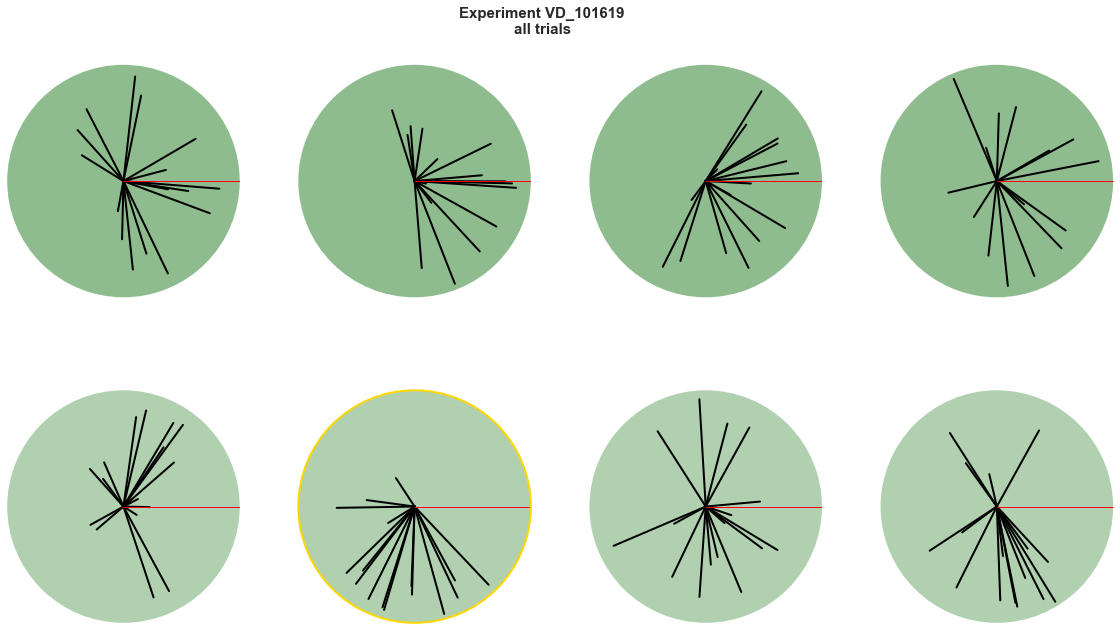

In [24]:
# # circular means plot

fig, axs = plt.subplots(2,4, figsize=(20, 10), facecolor='w', edgecolor='k', subplot_kw=dict(polar=True))
fig.subplots_adjust(hspace = .4)
fig.suptitle('Experiment '+exp+'\n'+'all trials',fontsize = 15, fontweight='bold')

axs = axs.ravel()
exp_trials_tp = [0,1,2,3,4,10,11,12]
axisorder = [0,1,2,3,4,5,6,7]
bckclr_labels = ['darkseagreen']
p_labels = ['Sun 1', 'Sun 2', 'Sun 2 and VP', 'Sun 1 and VP', 'Sun 1 and VF', 'VF']
for j in range(len(exp_trials_tp)):
    for i in range(len(all_circmeans_vf)):
        cms = all_circmeans_vf[i][exp_trials_tp[j]]
        cvs = all_circvars_vf[i][exp_trials_tp[j]]
        axs[axisorder[j]].plot((0, cms), ( 0, cvs), alpha = 1, color = 'k', linewidth =2)
        axs[axisorder[j]].plot((0, 0), ( 0, 1), alpha = 0.9, color = 'r', linewidth =1)
        axs[axisorder[j]].grid(False)
        axs[axisorder[j]].set_yticks([])
        axs[axisorder[j]].set_xticks([])
        axs[axisorder[j]].spines['polar'].set_visible(True)
        axs[axisorder[j]].set_rlim(0,1) 
        #xs[axisorder[j]].set_title(p_labels[j],fontsize = 15, fontweight='bold')
        
        if exp_trials_tp[j] in [0,1,2,3]:
            axs[axisorder[j]].patch.set_facecolor(bckclr_labels[0])
            axs[axisorder[j]].spines['polar'].set_ec(bckclr_labels[0])
#             axs[axisorder[j]].spines['polar'].set_ec('gold')
#             axs[axisorder[j]].spines['polar'].set_linewidth(2)
            
        elif exp_trials_tp[j] in [4]:
            axs[axisorder[j]].patch.set_facecolor(bckclr_labels[0])
            axs[axisorder[j]].spines['polar'].set_ec(bckclr_labels[0])
            axs[axisorder[j]].patch.set_alpha(0.7) 
#             axs[axisorder[j]].spines['polar'].set_ec('gold')
#             axs[axisorder[j]].spines['polar'].set_linewidth(2)
            
        elif exp_trials_tp[j] in [10]:
            axs[axisorder[j]].patch.set_facecolor(bckclr_labels[0])
            axs[axisorder[j]].spines['polar'].set_ec(bckclr_labels[0])
            axs[axisorder[j]].patch.set_alpha(0.7)
            axs[axisorder[j]].spines['polar'].set_ec('gold')
            axs[axisorder[j]].spines['polar'].set_linewidth(2) 
            
        elif exp_trials_tp[j] in [11,12]:
            axs[axisorder[j]].patch.set_facecolor(bckclr_labels[0])
            axs[axisorder[j]].spines['polar'].set_ec(bckclr_labels[0])
            axs[axisorder[j]].patch.set_alpha(0.7)          
            
        axs[axisorder[j]].xaxis.set_tick_params(labelsize=15, pad=10)
        
# axs[5].set_yticks([])
# axs[5].set_xticks([])
# axs[5].spines['polar'].set_visible(False)

# savefigdir = '/Users/fponce/Documents/vdesert/VD_101619/'
# fig.savefig(savefigdir+exp+'_polarplots_VF_'+'allflies'+'.pdf')  #bbox_inches='tight'        

In [25]:
#sun reference frame

In [26]:
#sun vfs
allangles = copy.deepcopy(all_magnotether_interp_angles)
allangles_sf = copy.deepcopy(all_magnotether_interp_angles)

all_led_angles_vda = []
for i in all_led_angles_vd:
    led_angles_vda = [0 if x=='NaN' else x for x in i]
    all_led_angles_vda.append(led_angles_vda)
        
for i in range(len(allangles_sf)):
    for j in range(len(all_start_frames_m[i])):
        allangles_sf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]] = get_smallestSignedAngleBetween(\
        allangles[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]], all_led_angles_vda[i][j])

In [27]:
#sun vfs
allangles = copy.deepcopy(all_magnotether_interp_angles)
allangles_sf = copy.deepcopy(all_magnotether_interp_angles)

all_led_angles_vda = []
for i in all_led_angles_vd:
    led_angles_vda = [0 if x=='NaN' else x for x in i]
    all_led_angles_vda.append(led_angles_vda)
        
for i in range(len(allangles_sf)):
    for j in range(len(all_start_frames_m[i])):
        allangles_sf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]] = get_smallestSignedAngleBetween(\
        allangles[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]], all_led_angles_vda[i][j])

In [28]:
#get circular means in sf reference frame
all_circmeans_sf = []
all_circmeans_deg_sf = []
all_circvars_sf = []
for i in range(len(allangles_sf)):
    circmeans_sf = []
    circmeans_deg_sf = []
    circvars_sf = []
    for j in range(len(all_start_frames[i])):
        angles_rad_sf = np.deg2rad(allangles_sf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]])
        circmeann_sf = circmean(angles_rad_sf)
        circvarr_sf = circvar(angles_rad_sf)
        circmeann_deg_sf = np.rad2deg(circmeann_sf)
        
        circmeans_sf.append((circmeann_sf))
        circmeans_deg_sf.append((circmeann_deg_sf))
        circvars_sf.append((circvarr_sf))
        
    all_circmeans_deg_sf.append(circmeans_deg_sf)
    all_circmeans_sf.append(circmeans_sf)
    all_circvars_sf.append(circvars_sf)

In [33]:
allangles_s1f = copy.deepcopy(allangles_sf)
        
#print(all_led_angles_vda)
for i in range(len(allangles_s1f)):
    for j in range(len(all_start_frames_m[i])):
        allangles_s1f[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]] = get_smallestSignedAngleBetween(\
        allangles_sf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]], all_circmeans_deg_sf[i][6])

In [34]:
#get circular means in sf reference frame
all_circmeans_s1f = []
all_circmeans_deg_s1f = []
all_circvars_s1f = []
for i in range(len(allangles_sf)):
    circmeans_s1f = []
    circmeans_deg_s1f = []
    circvars_s1f = []
    for j in range(len(all_start_frames[i])):
        angles_rad_s1f = np.deg2rad(allangles_s1f[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]])
        circmeann_s1f = circmean(angles_rad_s1f)
        circvarr_s1f = circvar(angles_rad_s1f)
        circmeann_deg_s1f = np.rad2deg(circmeann_s1f)
        
        circmeans_s1f.append((circmeann_s1f))
        circmeans_deg_s1f.append((circmeann_deg_s1f))
        circvars_s1f.append((circvarr_s1f))
        
    all_circmeans_deg_s1f.append(circmeans_deg_s1f)
    all_circmeans_s1f.append(circmeans_s1f)
    all_circvars_s1f.append(circvars_s1f)

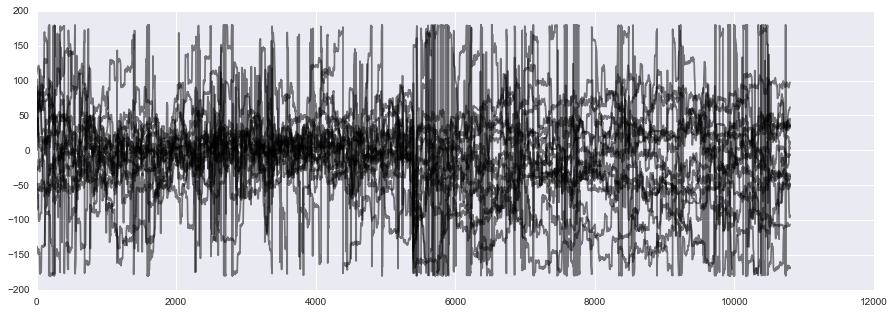

In [35]:
fig, ax1 = plt.subplots(1,1,figsize=(15, 5))
for i in range(len(allangles_sf)): 
    p = allangles_s1f[i][all_start_frames_m[i][6]:all_end_frames_m[i][7]]
    plt.plot(np.arange(len(p)),p,'k',alpha= 0.5)

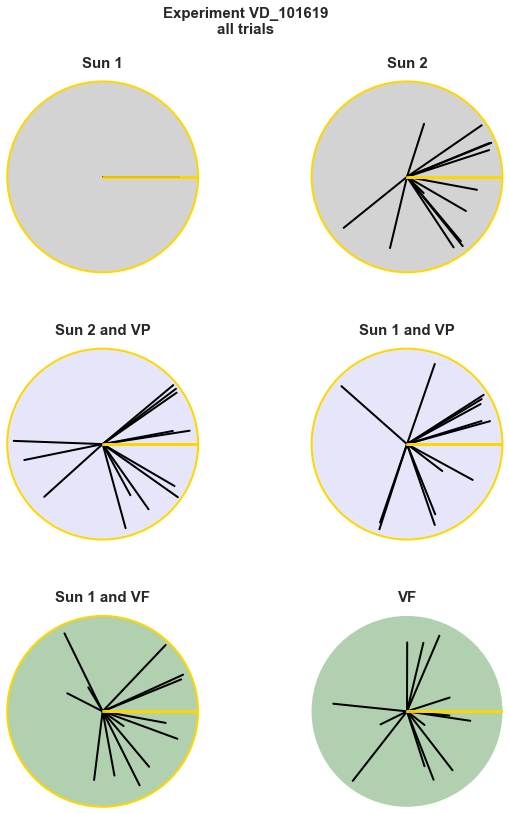

In [36]:
# # circular means plot

fig, axs = plt.subplots(3,2, figsize=(10, 13), facecolor='w', edgecolor='k', subplot_kw=dict(polar=True))
fig.subplots_adjust(hspace = .4)
fig.suptitle('Experiment '+exp+'\n'+'all trials',fontsize = 15, fontweight='bold')

axs = axs.ravel()
exp_trials_tp = [6,7,8,9,10,11]
axisorder = [0,1,2,3,4,5]
bckclr_labels = ['lightgray','lavender','darkseagreen']
p_labels = ['Sun 1', 'Sun 2', 'Sun 2 and VP', 'Sun 1 and VP', 'Sun 1 and VF', 'VF']
for j in range(len(exp_trials_tp)):
    for i in range(13):#(len(all_circmeans_sf)):
        cms = all_circmeans_s1f[i][exp_trials_tp[j]]
        cvs = all_circvars_s1f[i][exp_trials_tp[j]]
        axs[axisorder[j]].plot((0, cms), ( 0, cvs), alpha = 1, color = 'k', linewidth =2)
        axs[axisorder[j]].plot((0, 0), ( 0, 1), alpha = 0.9, color = 'gold', linewidth =3)
        axs[axisorder[j]].grid(False)
        axs[axisorder[j]].set_yticks([])
        axs[axisorder[j]].set_xticks([])
        axs[axisorder[j]].spines['polar'].set_visible(True)
        axs[axisorder[j]].set_rlim(0,1) 
        axs[axisorder[j]].set_title(p_labels[j],fontsize = 15, fontweight='bold')
        
        if exp_trials_tp[j] in [6,7]:
            axs[axisorder[j]].patch.set_facecolor(bckclr_labels[0])
            axs[axisorder[j]].spines['polar'].set_ec('gold')
            axs[axisorder[j]].spines['polar'].set_linewidth(2)
            
        elif exp_trials_tp[j] in [8,9]:
            axs[axisorder[j]].patch.set_facecolor(bckclr_labels[1])
            axs[axisorder[j]].spines['polar'].set_ec(bckclr_labels[0])
            axs[axisorder[j]].spines['polar'].set_ec('gold')
            axs[axisorder[j]].spines['polar'].set_linewidth(2)
            
        elif exp_trials_tp[j] in [10]:
            axs[axisorder[j]].patch.set_facecolor(bckclr_labels[2])
            axs[axisorder[j]].spines['polar'].set_ec(bckclr_labels[0])
            axs[axisorder[j]].patch.set_alpha(0.7)
            axs[axisorder[j]].spines['polar'].set_ec('gold')
            axs[axisorder[j]].spines['polar'].set_linewidth(2) 
            
        elif exp_trials_tp[j] in [11]:
            axs[axisorder[j]].patch.set_facecolor(bckclr_labels[2])
            axs[axisorder[j]].spines['polar'].set_ec(bckclr_labels[0])
            axs[axisorder[j]].patch.set_alpha(0.7)          
            
        axs[axisorder[j]].xaxis.set_tick_params(labelsize=15, pad=10)
        
#     savefigdir = '/Users/fponce/Documents/vdesert/VD_101619/'
#     fig.savefig(savefigdir+exp+'_polarplots_'+'allflies_t9'+'.pdf')  #bbox_inches='tight'        

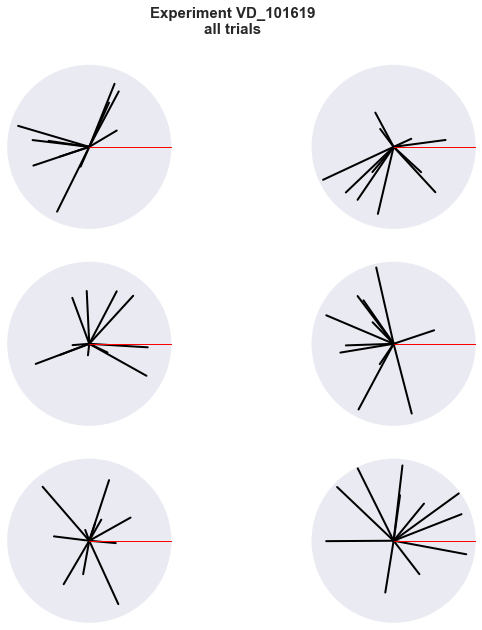

In [33]:
# # circular means plot

sns.set_style('dark')
fig, axs = plt.subplots(3,2, figsize=(10, 10), facecolor='w', edgecolor='k', subplot_kw=dict(polar=True))
#fig.subplots_adjust(hspace = .2, wspace=.01)
fig.suptitle('Experiment '+exp+'\n'+'all trials',fontsize = 15, fontweight='bold')

axs = axs.ravel()
exp_trials_tp = [6,7,8,9,10,11]
axisorder = [0,1,2,3,4,5]
bckclr_labels = ['lightgray','lavender','lightsteelblue']
for j in range(len(exp_trials_tp)):
    for i in range(len(all_circmeans_s1f)):
        cms = all_circmeans_s1f[i][j]
        cvs = all_circvars_s1f[i][j]
        axs[axisorder[j]].plot((0, cms), ( 0, cvs), alpha = 1, color = 'k', linewidth =2)#, s = 30, alpha = 0.9, color = 'k')
        axs[axisorder[j]].plot((0, 0), ( 0, 1), alpha = 0.9, color = 'r', linewidth =1)
        axs[axisorder[j]].grid(False)
        axs[axisorder[j]].set_yticks([])
        axs[axisorder[j]].set_xticks([])
        axs[axisorder[j]].spines['polar'].set_visible(False)
        axs[axisorder[j]].set_rlim(0,1) 
        #axs[axisorder[j]].set_title('WF set point: '+str(all_mid_set_points_tp[i][all_sorted_trials[i][j]]),fontsize = 15, fontweight='bold')
        
        #bf = all_mid_set_points_tp[i][all_sorted_trials[i][j]]
        
#         if bf==0:
#             axs[axisorder[j]].patch.set_facecolor(bckclr_labels[0])
#         elif bf==0.5:
#             axs[axisorder[j]].patch.set_facecolor(bckclr_labels[1])
#         elif bf==1.0:
#             axs[axisorder[j]].patch.set_facecolor(bckclr_labels[2])
    #ax1.patch.set_facecolor(bckclr_labels[all_pat_types[0][j]])
        axs[axisorder[j]].xaxis.set_tick_params(labelsize=15)

In [ ]:
#allangles = all_magnotether_interp_angles
allangles_vf = copy.deepcopy(allangles)

for i in range(len(allangles_vf)):
    for j in range(len(all_start_frames_m[i])):
        allangles_vf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]] = get_smallestSignedAngleBetween(\
        allangles[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]], all_autostep_angles[i][j])

In [13]:
#get the closest times that correspond to start and end times in the reg_t

all_sun_ts = get_elapsed_time(all_sun_ros_tstamps)
all_magnotether_elapsed = reg_t

all_start_times_s = []    
all_end_times_s = []   
for i in range(len(all_sun_ros_tstamps)): 
    start_times_trials_s = []
    end_times_trials_s = []    
    for j in range(len(all_sun_ros_tstamps[i])):
        start_times_s = find_nearest(reg_t, all_sun_ts[i][j])
        start_times_trials_s.append(start_times_s)
        try:
            end_times_s = find_nearest(reg_t, all_sun_ts[i][j+1])
            end_times_trials_s.append(end_times_s)
        except:
            pass
        
        all_start_times_s.append(start_times_trials_s)
        all_end_times_s.append(end_times_trials_s)
        
print(all_start_times_s[0])
print(all_end_times_s[0])

[0.0, 60.03333333333333, 120.1, 180.13333333333333, 240.2, 420.23333333333335, 430.26666666666665, 610.3, 970.3666666666667, 1330.4666666666667, 1510.5666666666666]
[60.03333333333333, 120.1, 180.13333333333333, 240.2, 420.23333333333335, 430.26666666666665, 610.3, 970.3666666666667, 1330.4666666666667, 1510.5666666666666]


In [ ]:
#